## Time-harmonic Maxwell's equations (B-field formulation)

### Weak form of the problem
From the derivation demonstrated in the notes, we know the weak form of the problem is given by

$$
\int_{\Omega} (\epsilon^{-1} \nabla \times (\mu^{-1} \mathbf{B})) \cdot (\nabla \times \mathbf{v})
    - \omega^2 \int_{\Omega} \mathbf{B} \cdot \mathbf{v}
    = \int_{\Omega} (\epsilon^{-1} \mathbf{j}) \cdot (\nabla \times \mathbf{v})
$$

for all $\mathbf{v} \in H_{\text{curl}}(\Omega)$ with boundary condition 

$$ \mathbf{v} \times \mathbf{n} = 0, ~\text{on}~\partial \Omega $$

with the normal vector $\mathbf{n}$ to $\partial \Omega$.

In [5]:
from fenics import *
from mshr import *
%matplotlib inline

In [15]:
D = 10.0 # radius of domain
R = 1 # radius of torus
r = 0.1 # tube-radius of torus

# Set the domain
domain = Sphere(Point(0, 0), D)

In [16]:
# Generating the mesh
mesh = generate_mesh(domain, 32)

# Define function space
V = FunctionSpace(mesh, 'N1curl', 1)

# Define integration measure
dx = Measure('dx', domain=mesh)

# Visuazlizing the mesh
#mesh

### Magnetic field strength (finite element solution)
Here, a toroidal current inside a sphere is assumed.

In [28]:
# Current along the torus
class current(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, value, x):
        value[2] = 0.0
        if pow((pow(x[0]**2 + x[1]**2, 0.5) - R)**2 + x[2]**2, 0.5) < r:
            value[0] = -x[1]
            value[1] = x[0]
        else:
            value[0] = 0.0
            value[1] = 0.0
    def value_shape(self):
        return (3,)

J = current(degree=2)

# Magnetic permeability for the configuration
class permeability(UserExpression):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def eval(self, value, x):
        if pow((pow(x[0]**2 + x[1]**2, 0.5) - R)**2 + x[2]**2, 0.5) < r:
            value[0] = 1.26e-6 # copper
        else:
            value[0] = 4*pi*1e-7 # vacuum
    def value_shape(self):
        return ()

mu = permeability(degree=2)

    Calling FFC just-in-time (JIT) compiler, this may take some time.
    Calling FFC just-in-time (JIT) compiler, this may take some time.


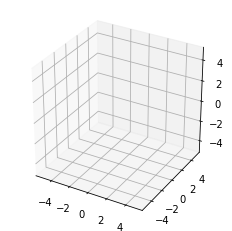

In [34]:
# Define boundary condition
bc = DirichletBC(V, Expression(('0.0', '0.0', '0.0'), degree=2), 'on_boundary')

# Define variational problem
B = TrialFunction(V)
v = TestFunction(V)

# Define stiffness and mass matrix
eps = 8.8e-12
a_stiff = (1 / (eps*mu))*dot(curl(B), curl(v))*dx
a_mass = dot(B, v)*dx
omega = 1000
a = a_stiff - (omega**2)*a_mass
L = (1 / eps)*dot(J, curl(v))*dx

# Solve variational problem
B = Function(V)
solve(a == L, B, bc)

plot(B)